In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


Initialiser Spark

In [2]:
# Principaux import
import findspark
print("findspark.init() initialise les variables d'environnement pour spark")
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *
#import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pyspark.sql import HiveContext

findspark.init() initialise les variables d'environnement pour spark


In [3]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
spark = SparkSession.builder \
    .appName("Big Data TP") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/01 22:55:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Chargement du dataset

In [5]:
# Chemin vers le dataset 
path ="african_crises.csv"

# Chargement des données
df = spark.read.csv(path, header=True, inferSchema=True)

In [6]:
df.show(5)

+----+---+-------+----+---------------+--------+------------------------+-------------------------------+--------------------+--------------------+------------+---------------+----------------+--------------+
|case|cc3|country|year|systemic_crisis|exch_usd|domestic_debt_in_default|sovereign_external_debt_default|gdp_weighted_default|inflation_annual_cpi|independence|currency_crises|inflation_crises|banking_crisis|
+----+---+-------+----+---------------+--------+------------------------+-------------------------------+--------------------+--------------------+------------+---------------+----------------+--------------+
|   1|DZA|Algeria|1870|              1|0.052264|                       0|                              0|                 0.0|         3.441455696|           0|              0|               0|        crisis|
|   1|DZA|Algeria|1871|              0|0.052798|                       0|                              0|                 0.0|         14.14913958|           0|    

In [7]:
# Renommage des colonnes pour correspondre aux noms attendus
df = df.withColumnRenamed('Year', 'year') \
       .withColumnRenamed('Systemic Crisis', 'systemic_crisis') \
       .withColumnRenamed('Inflation, Annual percentages of average consumer prices', 'inflation_annual_cpi') \
       .withColumnRenamed('Currency Crises', 'currency_crises') \
       .withColumnRenamed('Banking Crisis ', 'banking_crisis')

# Création de la vue temporaire
df.createOrReplaceTempView("african_crises")

In [8]:
df.columns

['case',
 'cc3',
 'country',
 'year',
 'systemic_crisis',
 'exch_usd',
 'domestic_debt_in_default',
 'sovereign_external_debt_default',
 'gdp_weighted_default',
 'inflation_annual_cpi',
 'independence',
 'currency_crises',
 'inflation_crises',
 'banking_crisis']

Renommer les colonnes pour faciliter la manipulation 

In [9]:
df = df.withColumnRenamed('Year', 'year') \
       .withColumnRenamed('Systemic Crisis', 'systemic_crisis') \
       .withColumnRenamed('Inflation, Annual percentages of average consumer prices', 'inflation_annual_cpi')

Pays avec le plus de crises systèmes entre 1970 et 1997

Méthode avec API DataFrame

Pays avec le plus de crises systémiques entre 1970 et 1907: Central African Republic


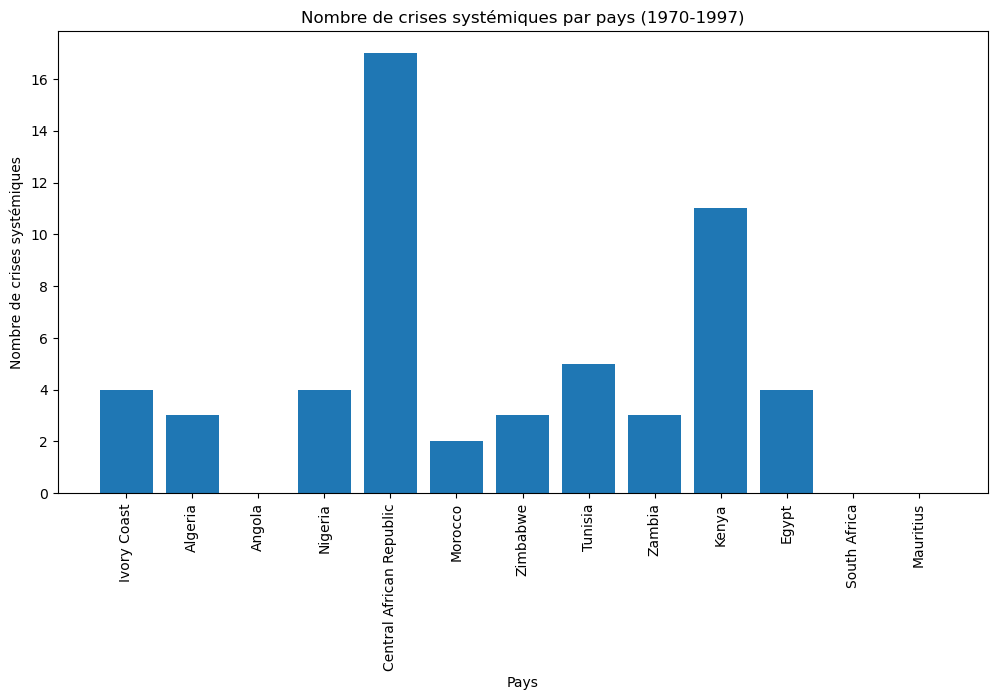

In [22]:
df_filtered = df.filter((df.year >= 1970) & (df.year <= 1997))
crises_per_country = df_filtered.groupBy("Country").agg({"systemic_crisis": "sum"})
crises_per_country = crises_per_country.withColumnRenamed("sum(systemic_crisis)", "total_crises")
country_most_crises = crises_per_country.orderBy(crises_per_country.total_crises.desc()).first()
print("Pays avec le plus de crises systémiques entre 1970 et 1907:", country_most_crises["Country"])

# Convertir en pandas DataFrame pour la visualisation
crises_per_country_pd = crises_per_country.toPandas()

# Visualisation
plt.figure(figsize=(12, 6))
plt.bar(crises_per_country_pd['Country'], crises_per_country_pd['total_crises'])
plt.xlabel('Pays')
plt.ylabel('Nombre de crises systémiques')
plt.title('Nombre de crises systémiques par pays (1970-1997)')
plt.xticks(rotation=90)
plt.show()


Méthode avec Spark SQL

In [24]:
query1 = """
SELECT Country, SUM(systemic_crisis) as total_crises
FROM african_crises
WHERE year >= 1970 AND year <= 1997
GROUP BY Country
ORDER BY total_crises DESC
LIMIT 1
"""
country_most_crises_sql = spark.sql(query1).first()
print("Pays avec le plus de crises systémiques entre 1970 et 1907:", country_most_crises_sql["Country"])

Pays avec le plus de crises systémiques entre 1970 et 1907: Central African Republic


Nombre moyen de crises systémiques par pays sur toute la période d'observation

Méthode avec API DataFrame

In [29]:
total_crises_per_country = df.groupBy("Country").agg({"systemic_crisis": "sum"})
total_crises_per_country = total_crises_per_country.withColumnRenamed("sum(systemic_crisis)", "total_crises")


Nombre moyen de crises systémiques par pays sur toute la période: 6.3076923076923075


Méthode avec Spark SQL

In [13]:
query2 = """
SELECT AVG(total_crises) as avg_crises
FROM (
    SELECT Country, SUM(systemic_crisis) as total_crises
    FROM african_crises
    GROUP BY Country
) as country_crises
"""
mean_crises_per_country_sql = spark.sql(query2).first()
print("Nombre moyen de crises systémiques par pays sur toute la période:", mean_crises_per_country_sql["avg_crises"])

Nombre moyen de crises systémiques par pays sur toute la période: 6.3076923076923075


Pays avec le plus grand taux de change vis-à-vis du dollar (USD) (le top 3 des plus grands)

Méthode avec API DataFrame

In [14]:
exchange_rate_top3 = df.orderBy(df.exch_usd.desc()).select("Country", "year", "exch_usd").distinct().limit(3).collect()
print("Top 3 pays avec le plus grand taux de change vis-à-vis du dollar (USD):")
for row in exchange_rate_top3:
    print(f"Pays: {row['Country']}, Année: {row['year']}, Taux de change: {row['exch_usd']}")

Top 3 pays avec le plus grand taux de change vis-à-vis du dollar (USD):
Pays: Central African Republic, Année: 1981, Taux de change: 287.3997967
Pays: Egypt, Année: 1868, Taux de change: 0.20661157
Pays: Egypt, Année: 1944, Taux de change: 0.2416


Méthode avec Spark SQL

In [15]:
query3 = """
SELECT DISTINCT Country, year, exch_usd
FROM african_crises
ORDER BY exch_usd DESC
LIMIT 3
"""
exchange_rate_top3_sql = spark.sql(query3).collect()
print("Top 3 pays avec le plus grand taux de change vis-à-vis du dollar (USD) (SQL):")
for row in exchange_rate_top3_sql:
    print(f"Pays: {row['Country']}, Année: {row['year']}, Taux de change: {row['exch_usd']}")

Top 3 pays avec le plus grand taux de change vis-à-vis du dollar (USD) (SQL):
Pays: Central African Republic, Année: 2001, Taux de change: 744.3061387
Pays: Central African Republic, Année: 2000, Taux de change: 704.9511016
Pays: Central African Republic, Année: 1999, Taux de change: 652.9534143


Pays avec le plus faible taux d’inflation annuelle (CPI) en 2004

Méthode avec API DataFrame

In [16]:
df_2004 = df.filter(df.year == 2004)
lowest_inflation_country = df_2004.orderBy(df_2004.inflation_annual_cpi.asc()).first()
print("Pays avec le plus faible taux d’inflation annuelle (CPI) en 2004:", lowest_inflation_country["country"])

Pays avec le plus faible taux d’inflation annuelle (CPI) en 2004: Central African Republic


Méthode avec Spark SQL

In [47]:
query4 = """
SELECT Country
FROM african_crises
WHERE year = 2004
ORDER BY inflation_annual_cpi ASC
LIMIT 1
"""
lowest_inflation_country_sql = spark.sql(query4).first()
print("Pays avec le plus faible taux d’inflation annuelle (CPI) en 2004",lowest_inflation_country_sql)

Pays avec le plus faible taux d’inflation annuelle (CPI) en 2004 Row(Country='Central African Republic')
